## Linear Regression Exercise

We will use a couple of the variables we measured, soil moisture content and aggregate stability to see if there is any relationship between them. The data is located here: https://github.com/gabbymyers/516X-Project/blob/master/_data/Class%20Exercise%20Data.xlsx.    

Soil moisture content refers to the moisture in the soil. We determine this by collecting a sample from each of our 36 plots at the Northeast Iowa Research Farm. The sample is taken back to the lab and the moisture content is determined by weighing the soil before and after drying.    

Aggregate stability is a measure of how the soil aggregates (groups of soil particles) fall apart when wet. We use the SLAKES app to get the aggregate stability numbers for our samples. The SLAKES app take continuous images of soil aggregates as they are submerged in water and returns aggregate stability values on a range of 0-14. The lower the number, the more stable the aggregates are. Stable aggregates indicate the soil likely has better water infiltration, reducing the risk of runoff. Cover crops are known to increase aggreagate stability, so I would expect our cover crop treatments to have lower aggregate stability values from the SLAKES app.

### Research Question:

Is there any relationship between aggregate stability and moisture content?

In [45]:
# imports
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
# allow plots to appear directly in the notebook
%matplotlib inline

#### Read the soil moisture data into its own data frame.

In [16]:
soil_moisture = pd.read_excel('Class Exercise Data.xlsx', sheet_name = 'Soil Moisture' )
soil_moisture.head()

,Plot Number,Treatment,Block,Sample Date,Moisture Content,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,1,2S,2,1,0.050720,NaN,NaN,NaN
1,2,6S,2,1,0.053265,NaN,NaN,NaN
2,3,1C,2,1,0.075589,NaN,NaN,NaN
3,4,3.1,2,1,0.059354,NaN,NaN,NaN
4,5,4.1,2,1,0.082545,NaN,NaN,NaN


In [19]:
soil_moisture = soil_moisture.iloc[ : ,0:5]
soil_moisture.head()

,Plot Number,Treatment,Block,Sample Date,Moisture Content
0,1,2S,2,1,0.050720
1,2,6S,2,1,0.053265
2,3,1C,2,1,0.075589
3,4,3.1,2,1,0.059354
4,5,4.1,2,1,0.082545


In [20]:
max(soil_moisture["Sample Date"])

12

We have 12 weeks of data for the soil moisture content. 

#### Read the aggregate stability data into its own data frame. 

In [21]:
aggregate_stability = pd.read_excel('Class Exercise Data.xlsx', sheet_name = 'Slake')
aggregate_stability.head()

,Plot,Treatment,Block,Date,Aggregate Stability,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,1,2S,2,1,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,6S,2,1,6.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1C,2,1,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3.1,2,1,1.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,4.1,2,1,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We need to filter out the extra columns that are contained in the aggregate stability data frame. 

In [22]:
aggregate_stability = aggregate_stability.iloc[ : ,0:5]
aggregate_stability.head()

,Plot,Treatment,Block,Date,Aggregate Stability
0,1,2S,2,1,2.5
1,2,6S,2,1,6.2
2,3,1C,2,1,2.5
3,4,3.1,2,1,1.7
4,5,4.1,2,1,0.8


Make sure that the dates match the soil moisture so we have the same amount of data:

In [23]:
max(aggregate_stability['Date'])

10

We only have 10 weeks of data for aggregate stability, so we need to filter out the extra two weeks of soil moisture data. 10 weeks * 36 plots = 360 rows of data. 

In [24]:
soil_moisture = soil_moisture.iloc[0:360, : ]
max(soil_moisture['Sample Date'])

10

In [25]:
soil_moisture

,Plot Number,Treatment,Block,Sample Date,Moisture Content
0,1,2S,2,1,0.050720
1,2,6S,2,1,0.053265
2,3,1C,2,1,0.075589
3,4,3.1,2,1,0.059354
4,5,4.1,2,1,0.082545
...,...,...,...,...,...
355,32,3.2,1,10,0.159200
356,33,3.1,3,10,0.153900
357,34,5C,3,10,0.148500
358,35,4.2,3,10,0.161500


I wanted to make sure that the last row of data is correct. It is because it is plot 36 on date 10. 

#### Merging the data frames
First we need to rename the columns so the are the same across the different data frames. 

In [27]:
soil_moisture = soil_moisture.rename(columns={'Plot Number': 'Plot'})
soil_moisture = soil_moisture.rename(columns={'Sample Date': 'Date'})

Now we can merge the two data frames

In [37]:
merged_data = pd.merge(left=soil_moisture,right=aggregate_stability, 
                       left_on=['Plot','Treatment', 'Block', 'Date'], right_on=['Plot','Treatment','Block', 'Date'])
merged_data.head()

,Plot,Treatment,Block,Date,Moisture Content,Aggregate Stability
0,1,2S,2,1,0.050720,2.5
1,2,6S,2,1,0.053265,6.2
2,3,1C,2,1,0.075589,2.5
3,4,3.1,2,1,0.059354,1.7
4,5,4.1,2,1,0.082545,0.8


In [38]:
merged_data.isna().sum() 

Plot                   0
Treatment              0
Block                  0
Date                   0
Moisture Content       0
Aggregate Stability    4
dtype: int64

In [39]:
merged_data.shape

(360, 6)

There are four na values in the aggregate stability column. I am going to drop these rows. 

In [40]:
merged_data = merged_data.dropna()
merged_data.shape

(356, 6)

In [ ]:
#### Explore the data

### Regression

Plot moisture content vs. aggregate stability to see if you can see any relationship.

Text(0, 0.5, 'Aggregate Stability')

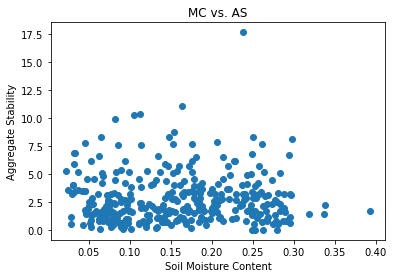

In [58]:
plt.scatter(merged_data['Moisture Content'], merged_data['Aggregate Stability'])
plt.title('MC vs. AS')
plt.xlabel('Soil Moisture Content')
plt.ylabel('Aggregate Stability')

In [61]:
X = merged_data['Moisture Content']
Y = merged_data['Aggregate Stability']
print(X.shape)
print(Y.shape)

(356,)
(356,)


Using scipy.stats.linregress (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html)

In [67]:
res = sp.stats.linregress(X, Y)
print(f"R-squared: {res.rvalue**2:.6f}")
print(f"Slope: {res.slope:.6f}")
print(f"Intercept: {res.intercept:.6f}")

R-squared: 0.001122
Slope: 0.946637
Intercept: 2.570731


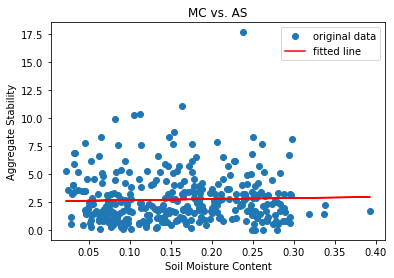

In [69]:
plt.plot(X, Y, 'o', label='original data')
plt.plot(X, res.intercept + res.slope*X, 'r', label='fitted line')
plt.title('MC vs. AS')
plt.xlabel('Soil Moisture Content')
plt.ylabel('Aggregate Stability')
plt.legend()
plt.show()


#### Using the method we learned in class: 

In [72]:
X = X[:, np.newaxis]
print(X.shape)

(356, 1)


<ipython-input-72-44f8d95ed655>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, np.newaxis]


In [73]:
model = LinearRegression(fit_intercept=True)
model
model.fit(X,Y)

LinearRegression()

In [74]:
model.coef_

array([0.94663685])

In [75]:
model.intercept_

2.5707314408029305

### Equation: Y = 0.9466X + 2.57073